In [17]:
from functions import vectorize_y_ser

In [18]:
import datetime

In [19]:
import nltk
import string

In [20]:
import re

In [21]:
import pickle

In [22]:
import pandas as pd
import numpy as np

In [23]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [25]:
from collections import Counter

In [26]:
from imblearn.under_sampling import RandomUnderSampler

In [27]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLP Pipeline 

![](images/pipeline-walkthrough1.png)

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors

Let's go through both what each of these steps are and how to do them in python with the following corpus of comments about data science...
 

In [28]:
# function to vectorize the type_of_material series into a y target vector.
def vectorize_y_ser(ser):
    y = ser.copy()
    y.replace({'Op-Ed': 1,'News': 0}, inplace=True)
    return y

In [29]:
#rate of correct predictions out of total predictions
def metrics_(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    print(f'Accuracy: {round(accuracy, 2)}')
    recall = (tp) / (tp + fn)
    print(f'Recall: {round(recall, 2)}')
    precision = (tp) / (tp + fp)
    print(f'Precision: {round(precision, 2)}')
    print(f'TN:{tn} FP:{fp} FN:{fn} TP:{tp}')

In [30]:
#prints number of features, stop words and parameters for vectorizer
def vectorizer_parameters(vectorizer):
    #features
    feat_names = vectorizer.get_feature_names()
    num_feat = len(feat_names)
    
    #stop words
    stop_words = vectorizer.stop_words_
    num_stop = len(stop_words)

    params = vectorizer.get_params()
    
    print(f'Number of features: {num_feat}, Numbers of stop words: {num_stop}')
      
    for key, val in params.items():
        print(f'{key}: {val}')

In [31]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’“':
            document = document.replace(char, " ") 
    return document

In [32]:
import os
import glob
import pandas as pd

#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
df2020 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2020.csv'
df2019 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2019.csv'
df2018 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2018.csv'
df2017 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2017.csv'
df2016 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2016.csv'
df2015 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2015.csv'
df2014 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2014.csv'
df2013 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2013.csv'
df2012 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2012.csv'
df2011 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2011.csv'
df2010 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2010.csv'
df2009 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2009.csv'
df2008 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2008.csv'
df2007 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2007.csv'
df2006 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2006.csv'
df2005 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2005.csv'
df2004 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2004.csv'
df2003 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2003.csv'
df2002 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2002.csv'
df2001 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2001.csv'
df2000 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2000.csv'
df1999 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1999.csv'
df1998 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1998.csv'
df1997 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1997.csv'
df1996 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1996.csv'
df1995 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1995.csv'
df1994 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1994.csv'
df1993 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1993.csv'
df1992 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1992.csv'
df1991 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1991.csv'
df1990 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1990.csv'
df1989 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1989.csv'
df1988 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1988.csv'
df1987 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1987.csv'
df1986 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1986.csv'
df1985 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1985.csv'
df1984 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1984.csv'
df1983 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1983.csv'
df1982 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1982.csv'
df1981 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_1981.csv'

In [33]:
#combine print, type, text columns in the list
def printed(file):
    print_cols = ['_id','print_page','pub_date','keywords','type_of_material','text']
    df = pd.read_csv(file, usecols=print_cols, index_col='_id', low_memory=False)
    df = df[df.print_page.isna() == False]
    df = df[~df.text.isna() == True]
    return df

In [34]:
#returns articles w/ 'United States Politics and Government' as a keyword
def return_pol_gov(row):
    list_dict = eval(row.keywords)
    for (dic) in (list_dict):
        if dic.get('value') == 'United States Politics and Government':
            return True

In [35]:
def filter_keyword(df, keyword='United States Politics and Government'):
    df[keyword] = df.apply(return_pol_gov, axis=1)
    df = df[df[keyword] == True]
    return df

In [87]:
#returns shape of news and oped
def oped_v_news(df):
    df.type_of_material.hist()
    news = sum(df.type_of_material == "News")
    oped = sum(df.type_of_material == "Op-Ed")
    print(f'News: {news} Oped: {oped}, Total: {oped+news}, Op-Ed {round(oped/(oped+news), 2)} of total')
    plt.savefig('img/oped_news_hist.png')

In [37]:
#split article and return quote
def return_quote(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
        
    return(quotation)

In [38]:
#split article and return quote
def return_article(document):
    article = []
    quote_list = []
    
    open_quote = "“"
    close_quote = "”"
    
    close_split = document.split(close_quote)
    
    for string in close_split:

        quote = string.split(open_quote)
        article.append(quote.pop(0))
        quote_list += quote
    
    article = " ".join(article)
    quotation = " ".join(quote_list)
    
    return(article)

In [39]:
data = printed(df2020)

In [40]:
%%time
df = data.copy()

CPU times: user 1.4 ms, sys: 605 µs, total: 2.01 ms
Wall time: 1.51 ms


In [41]:
df.shape

(27752, 5)

In [42]:
df = filter_keyword(df)

In [75]:
df.shape

(4585, 6)

In [76]:
df['article'] = df.text.apply(return_article)
df['quotation'] = df.text.apply(return_quote)

In [77]:
df.head()

,keywords,pub_date,type_of_material,print_page,text,United States Politics and Government,article,quotation
_id,,,,,,,,
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e,"[{'name': 'persons', 'value': 'Barr, William P...",2020-06-01T09:00:11+0000,News,20.0,"On the first Monday in May, the Department of ...",True,"On the first Monday in May, the Department of ...",exposed to any person diagnosed I’m not going ...
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3,"[{'name': 'subject', 'value': 'Presidential El...",2020-06-01T09:01:09+0000,News,14.0,"Under normal circumstances, Joseph R. Biden Jr...",True,"Under normal circumstances, Joseph R. Biden Jr...","He’s been present, I don’t think it matters to..."
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf,"[{'name': 'organizations', 'value': 'Supreme C...",2020-06-01T16:38:59+0000,News,15.0,The Supreme Court on Monday unanimously upheld...,True,The Supreme Court on Monday unanimously upheld...,officers of the United States. a labyrinthine ...
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568,"[{'name': 'subject', 'value': 'Coronavirus (20...",2020-06-01T16:42:18+0000,News,6.0,"An international team of scientists, including...",True,"An international team of scientists, including...",the real hot spot for these viruses. People ar...
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c,"[{'name': 'subject', 'value': 'George Floyd Pr...",2020-06-01T17:20:54+0000,News,1.0,WASHINGTON — President Trump on Monday angrily...,True,WASHINGTON — President Trump on Monday angrily...,organizers If a city or a state refuses to tak...


In [78]:
df.article.iloc[0]

'On the first Monday in May, the Department of Justice headquarters in Washington was on coronavirus lockdown — or at least it appeared to be from the outside. Signs posted on the outer doors facing Constitution Avenue admonished visitors to keep out if they had symptoms of Covid-19 or had been   with it. Inside, the guards operating the X-ray machines wore masks and gloves. Across the lobby, a free-standing pump of hand sanitizer cast a cautionary shadow down empty marble halls.But as you drew closer to the fifth floor, where Attorney General William Pelham Barr works out of a suite of offices, things started to loosen up. One assistant outside his conference room wore a mask, but the other did not. In the middle of the room, with its oil paintings and vaulted ceiling, the long central table had fewer chairs than you might expect, and an appropriate distance between them. But past the next door, inside the attorney general’s smaller personal office, Barr himself was also mask-free. Tu

In [79]:
last_check_before_split = (df.iloc[0])
last_check_before_split

keywords                                 [{'name': 'persons', 'value': 'Barr, William P...
pub_date                                                          2020-06-01T09:00:11+0000
type_of_material                                                                      News
print_page                                                                              20
text                                     On the first Monday in May, the Department of ...
United States Politics and Government                                                 True
article                                  On the first Monday in May, the Department of ...
quotation                                exposed to any person diagnosed I’m not going ...
Name: nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e, dtype: object

News: 3731 Oped: 760, Total: 4491, Op-Ed 0.17 of total


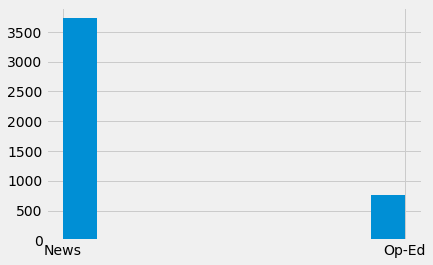

In [150]:
oped_v_news(df)

In [255]:
testdf = pd.read_csv('test2020.csv',index_col='_id')

In [259]:
testdf.columns

Index(['web_url', 'lead_paragraph', 'keywords', 'pub_date', 'type_of_material',
       'print_page', 'text', 'United States Politics and Government',
       'strip_lead', 'article', 'quotation', 'keyword_list'],
      dtype='object')

In [260]:
testdf.keyword_list

_id
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e    ['', 'Barr,', 'William', 'P', 'Justice', 'Depa...
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3    ['', 'Presidential', 'Election', 'of', '2020',...
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf    ['', 'Supreme', 'Court', '(US)', 'Puerto', 'Ri...
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568    ['', 'Coronavirus', '(2019-nCoV)', 'Bats', 'SA...
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c    ['', 'George', 'Floyd', 'Protests', '(2020)', ...
                                                                            ...                        
nyt://article/2bfafff5-96ce-5dba-acf8-e2d5f8eab27e    ['', 'Presidents', 'and', 'Presidency', '(US)'...
nyt://article/7254685b-f45b-5165-a4a0-8aeab43d9841    ['', 'Forced', 'Labor', 'United', 'States', 'P...
nyt://article/78e5cf9b-da8f-5fe1-8b69-4f91d4c5e174    ['', 'California', 'Senate', 'United', 'States...
nyt://article/12aacb9c-8972-5cce-add8-c8c0cebe74e0    ['', '

In [261]:
df.quotation

AttributeError: 'DataFrame' object has no attribute 'quotation'

# X, y

In [145]:
#define X. X is currently pandas series of unsplit strings
X = df.article

In [147]:
#turn series into list...
corpus = list(X)

In [148]:
# define y as a series of op-ed or news
y = df.type_of_material

In [151]:
vectorize_y_ser(y)

_id
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e    0
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3    0
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf    0
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568    0
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c    0
                                                     ..
nyt://article/2bfafff5-96ce-5dba-acf8-e2d5f8eab27e    1
nyt://article/7254685b-f45b-5165-a4a0-8aeab43d9841    0
nyt://article/78e5cf9b-da8f-5fe1-8b69-4f91d4c5e174    0
nyt://article/12aacb9c-8972-5cce-add8-c8c0cebe74e0    0
nyt://article/34f9a992-f1c9-53f7-ad81-67d9f064908e    0
Name: type_of_material, Length: 4491, dtype: int64

In [152]:
%%time
# vectorize y in to (1, 0) (op-ed, news)
y = vectorize_y_ser(y)

CPU times: user 2.01 ms, sys: 511 µs, total: 2.52 ms
Wall time: 2.02 ms


In [153]:
y.value_counts()

0    3731
1     760
Name: type_of_material, dtype: int64

In [154]:
y.shape

(4491,)

# remove stop words

# stemming/lemmatization

In [155]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [156]:
# %%time
# def snowball_tokenize(doc):
#     snowball = SnowballStemmer('english')
#     return [snowball.stem(word) for word in word_tokenize(doc.lower())]

In [157]:
%%time
def wordnet_tokenize(doc):
    wordnet = WordNetLemmatizer()
    return  [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


# vectorizer

# WORDNET tfidf

In [158]:
import string

In [159]:
print(string.punctuation)
print('!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~’')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+—,-./:;<=>?@[\]^_`{|}~’


In [160]:
# nytimes_quotes = "”“"
# nytimes_punctuation = "—"

In [161]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~’':
            document = document.replace(char, " ")
    return document

In [162]:
base_news = ['about',
 'administration',
 'after',
 'against',
 'all',
 'also',
 'american',
 'an',
 'and',
 'another',
 'any',
 'are',
 'at',
 'back',
 'be',
 'because',
 'been',
 'before',
 'being',
 'both',
 'but',
 'by',
 'called',
 'campaign',
 'can',
 'come',
 'congress',
 'could',
 'country',
 'day',
 'democrat',
 'democratic',
 'did',
 'do',
 'don',
 'down',
 'during',
 'election',
 'even',
 'federal',
 'first',
 'for',
 'former',
 'from',
 'get',
 'go',
 'going',
 'government',
 'group',
 'ha',
 'had',
 'have',
 'he',
 'him',
 'his',
 'house',
 'how',
 'if',
 'in',
 'including',
 'into',
 'is',
 'issue',
 'it',
 'just',
 'last',
 'law',
 'leader',
 'like',
 'long',
 'made',
 'make',
 'many',
 'may',
 'member',
 'month',
 'more',
 'most',
 'mr',
 'much',
 'national',
 'new',
 'no',
 'not',
 'now',
 'of',
 'office',
 'official',
 'on',
 'one',
 'only',
 'or',
 'other',
 'our',
 'out',
 'over',
 'own',
 'part',
 'party',
 'people',
 'policy',
 'political',
 'president',
 'public',
 're',
 'republican',
 'right',
 'said',
 'say',
 'senate',
 'senator',
 'she',
 'should',
 'since',
 'so',
 'some',
 'state',
 'still',
 'such',
 'take',
 'than',
 'that',
 'the',
 'their',
 'them',
 'then',
 'there',
 'these',
 'they',
 'think',
 'this',
 'those',
 'through',
 'time',
 'to',
 'trump',
 'two',
 'under',
 'united',
 'up',
 'very',
 'wa',
 'want',
 'washington',
 'way',
 'we',
 'week',
 'well',
 'were',
 'what',
 'when',
 'where',
 'whether',
 'which',
 'while',
 'white',
 'who',
 'will',
 'with',
 'work',
 'would',
 'year',
 'you']

In [163]:
names = ['donald','joseph','jr','joe']

In [188]:
stop = ['said' 'mr','our','trump','biden','america','american','need']

In [189]:
alphabet = ['a','b','c','d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stop_words = alphabet + base_news + names + stop

In [219]:
%%time
#create vectorizer

vectorizer = TfidfVectorizer(#input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict', 
#                 strip_accents='ascii', 
#                 lowercase=True, 
                 preprocessor=punc_strip, 
                 tokenizer=wordnet_tokenize, 
#                 analyzer='word', 
                 stop_words=stop_words,
#                 token_pattern='(?u)\b\w\w+\b', 
#                 ngram_range=(1, 1), 
#                 max_df=0.85, 
 #                min_df=0.1, 
                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
)

CPU times: user 541 µs, sys: 27 µs, total: 568 µs
Wall time: 574 µs


# test, train, split

In [220]:
#test, train, split

In [221]:
%%time
#test, train, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3368,) (1123,) (3368,) (1123,)
CPU times: user 2.14 ms, sys: 385 µs, total: 2.53 ms
Wall time: 2.36 ms


In [222]:
sum(X_train.isna())    

0

In [223]:
%%time
print(datetime.datetime.now())
X_train = vectorizer.fit_transform(X_train)

2021-01-09 21:57:51.887605
CPU times: user 5.41 s, sys: 33.1 ms, total: 5.45 s
Wall time: 5.47 s


In [224]:
%%time
print(datetime.datetime.now())
X_test = vectorizer.transform(X_test)

2021-01-09 21:57:57.365606
CPU times: user 1.73 s, sys: 9.44 ms, total: 1.74 s
Wall time: 1.74 s


In [225]:
vocab = vectorizer.vocabulary_

In [226]:
len(vocab)

19188

In [227]:
X_train.shape

(3368, 19188)

In [228]:
X_test.shape

(1123, 19188)

# count vectorizer

In [229]:
# count_vectorizer = CountVectorizer(strip_accents='None',
#                                    lowercase=True,
#                                    tokenizer=snowball_tokenize,
#                                    stop_words='english',
#                                    max_features=None)

# balance classes

In [230]:
%%time
#balance the classes

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

#X, y --> X_resampled, y_resampled
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print(rus)

[(0, 574), (1, 574)]
RandomUnderSampler(random_state=0)
CPU times: user 3.58 ms, sys: 1.19 ms, total: 4.77 ms
Wall time: 3.75 ms


# random forest classifier

In [231]:
%%time
print(datetime.datetime.now())
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)

2021-01-09 21:57:59.152056
CPU times: user 369 µs, sys: 52 µs, total: 421 µs
Wall time: 381 µs


In [232]:
rf_clf.fit(X_resampled, y_resampled)
y_pred = rf_clf.predict(X_test)
y_pred.shape

(1123,)

### metrics y_pred

In [233]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()

In [234]:
print(y_test.shape)
print(y_pred.shape)

(1123,)
(1123,)


In [235]:
metrics_(tn, fp, fn, tp)

Accuracy: 0.72
Recall: 0.83
Precision: 0.36
TN:658 FP:279 FN:32 TP:154


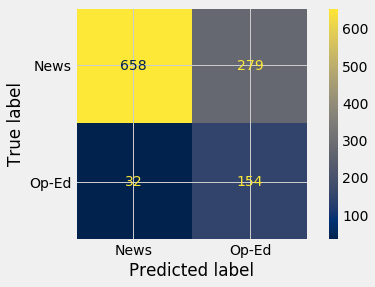

In [236]:
class_names = ["News", "Op-Ed"]
plot_confusion_matrix(estimator=rf_clf,
                      X=X_test,
                      y_true=y_test,
                      display_labels=class_names,
                      cmap='cividis')
plt.savefig('img/confusion_matrix.png');

# vectorizer parameters

In [237]:
vectorizer_parameters(vectorizer)

Number of features: 19188, Numbers of stop words: 0
analyzer: word
binary: False
decode_error: strict
dtype: <class 'numpy.float64'>
encoding: utf-8
input: content
lowercase: True
max_df: 1.0
max_features: None
min_df: 1
ngram_range: (1, 1)
norm: l2
preprocessor: <function punc_strip at 0x7fbf3efcb0e0>
smooth_idf: True
stop_words: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'about', 'administration', 'after', 'against', 'all', 'also', 'american', 'an', 'and', 'another', 'any', 'are', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'both', 'but', 'by', 'called', 'campaign', 'can', 'come', 'congress', 'could', 'country', 'day', 'democrat', 'democratic', 'did', 'do', 'don', 'down', 'during', 'election', 'even', 'federal', 'first', 'for', 'former', 'from', 'get', 'go', 'going', 'government', 'group', 'ha', 'had', 'have', 'he', 'him', 'his', 'house', 'how', 'if', 'in', 'including', 'into', 'is',

# important features

### feature imporance

2021-01-09 21:57:59.616225
CPU times: user 353 ms, sys: 20.7 ms, total: 374 ms
Wall time: 374 ms


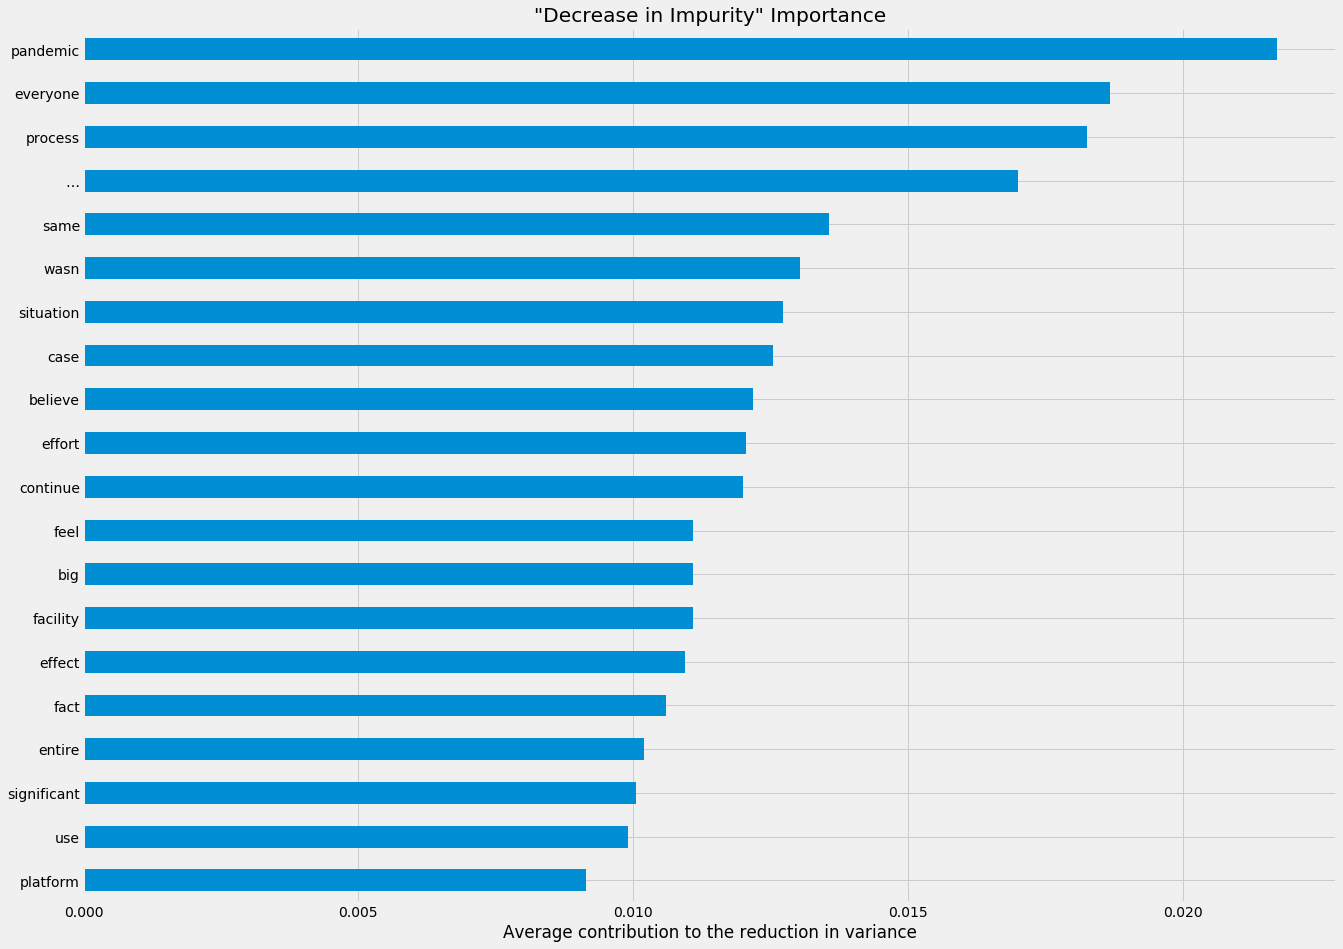

In [238]:
%%time
print(datetime.datetime.now())

feat_names = vectorizer.get_feature_names()
feature_import = rf_clf.feature_importances_

feat_scores = pd.Series(feature_import, index=feat_names)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', figsize=(20,15))
ax.set_title('"Decrease in Impurity" Importance')
ax.set_xlabel('Average contribution to the reduction in variance')
plt.savefig('img/feature_imporance.png');

In [239]:
feat_scores[-50:]

voter           0.006082
moment          0.006091
bad             0.006137
testing         0.006212
higher          0.006316
value           0.006388
forward         0.006391
appropriate     0.006397
death           0.006445
agreement       0.006505
doe             0.006505
conversation    0.006522
got             0.006567
health          0.006663
address         0.006683
job             0.006687
having          0.006754
consistent      0.006778
looking         0.006941
my              0.006998
help            0.007039
see             0.007690
doing           0.007725
choice          0.007789
security        0.007809
better          0.007813
done            0.007933
ll              0.008287
anybody         0.008538
future          0.008925
platform        0.009136
use             0.009913
significant     0.010063
entire          0.010198
fact            0.010603
effect          0.010940
facility        0.011085
big             0.011092
feel            0.011095
continue        0.011999


### permutation importance

In [240]:
# %%time
# print(datetime.datetime.now())
# r = permutation_importance(rf_clf, X_test.toarray(), y_test, n_repeats=30, random_state=0)

In [241]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [242]:
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<20}")
# #               f"{r.importances_mean[i]:.3f}"
# #               f" +/- {r.importances_std[i]:.3f}")

In [254]:
len(feat_names)

19188

# make a plot

In [244]:
y

_id
nyt://article/f5d2e4a7-f89b-54da-9985-dd5fc704a51e    0
nyt://article/0fa09b77-5faa-588f-9d4a-39a34748c7f3    0
nyt://article/6b274a69-c82b-5b68-bada-ec1467440ddf    0
nyt://article/8867f9cb-5914-5731-90b9-e1f1781fa568    0
nyt://article/fb5f6e07-033e-5618-967e-fbc1ebcfd61c    0
                                                     ..
nyt://article/2bfafff5-96ce-5dba-acf8-e2d5f8eab27e    1
nyt://article/7254685b-f45b-5165-a4a0-8aeab43d9841    0
nyt://article/78e5cf9b-da8f-5fe1-8b69-4f91d4c5e174    0
nyt://article/12aacb9c-8972-5cce-add8-c8c0cebe74e0    0
nyt://article/34f9a992-f1c9-53f7-ad81-67d9f064908e    0
Name: type_of_material, Length: 4491, dtype: int64

In [245]:
min_df = np.linspace(0,.4,5)

In [246]:
min_df

array([0. , 0.1, 0.2, 0.3, 0.4])

In [247]:
corpus[0]

'exposed to any person diagnosed I’m not going to insist that you have a mask, rumpled, If you want to take it off … , I’m not going to infect you, Go ahead and take it off, opportunistic the product of some festering injustice. respect and support, might find themselves without the police protection they need. freedom liberate liberation disfavored speech and undue interference with the national economy. total I think the federal government does have the power to step in where a state is impairing interstate commerce, where they’re intruding on civil liberties, or where Congress under the commerce clause — or some other power Congress has — has given the president under emergency authorities that essentially pre-empt the states in a particular area, if he chooses to use them. other power. total illegal doesn’t work out well for Republicans. The voters. I haven’t looked into that, one of the issues that I’m real worried about, We’ve been talking about how, in terms of foreign influence

In [248]:
%%time
num_feat_min = []

min_df = np.linspace(0,.4,5)

for val in min_df:
    vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip,
#                 tokenizer=wordnet_tokenize,
#                 stop_words=stop_words,
#                 max_df=0.95,
                 min_df=val,
                 max_features=None)
    
    vectorizer_plot.fit(corpus)
    
    features = vectorizer_plot.get_feature_names()
    stop_word = vectorizer_plot.get_stop_words()

    num_feat_min.append(len(features))

CPU times: user 4.3 s, sys: 65.9 ms, total: 4.37 s
Wall time: 4.39 s


CPU times: user 11.3 ms, sys: 1.56 ms, total: 12.9 ms
Wall time: 11.7 ms


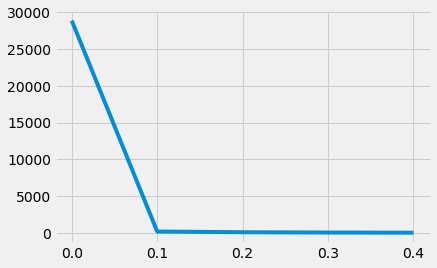

In [249]:
%%time
fig, ax = plt.subplots()
ax.plot(min_df, num_feat_min);

In [250]:
%%time
num_feat_max = []

max_df = np.linspace(.7,1,3)

for val in max_df:
    vectorizer_plot = TfidfVectorizer(preprocessor=punc_strip, 
#                 tokenizer=wordnet_tokenize, 
#                 stop_words=stop_words,
                 max_df=val,
#                 min_df=val, 
                 max_features=None)
    vectorizer_plot.fit_transform(corpus)
    features = vectorizer_plot.get_feature_names()
    stop_word = vectorizer_plot.get_stop_words()

    num_feat_max.append(len(features))

CPU times: user 2.7 s, sys: 33.6 ms, total: 2.73 s
Wall time: 2.74 s


CPU times: user 11.1 ms, sys: 1.59 ms, total: 12.7 ms
Wall time: 11.4 ms


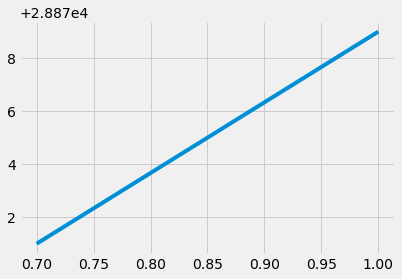

In [251]:
%%time
fig, ax = plt.subplots()
ax.plot(max_df, num_feat_max);

In [252]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)
    
# fig, ax = plt.subplots()
# ax.plot(features, scores)

In [253]:
# for f in features:
#     model = RandomForestClassifier(max_features=f)
#     score = cross_val_score(model, X, y).mean()
#     print('A Random Forest Regressor with max features of: {} gets a score of {}'
#           .format(f,score))
#     scores.append(score)